# Elden Ring: The Architecture of Fate

## Complete Research Pipeline

This notebook combines the entire research workflow: Data Collection, Graph Construction, Network Analysis, and NLP Analysis.

# Section: 01_data_collection.ipynb

# 01. Data Collection (Week 1)

## Week 1: APIs & Data Acquisition

**Research Question:** "To what extent do game mechanics (specifically stat scaling and item utility) dictate the narrative topology and character fates of the Elden Ring universe?"

### Course Concepts Applied
-   **APIs:** Interacting with the Elden Ring Fan API.
-   **Data Handling:** Pagination, Rate Limiting, and Caching (JSON).
-   **Reproducibility:** Creating a robust data pipeline.

**Endpoints:** `items`, `weapons`, `npcs`, `locations`, `bosses`, `armors`, `talismans`, `incantations`.

In [12]:
import datetime as dt
import json
import sys
import time
from pathlib import Path
from typing import Dict, List, Sequence

import requests

CANDIDATES = [Path.cwd(), Path.cwd().parent, Path.cwd().parents[1]]
PROJECT_ROOT = None
for candidate in CANDIDATES:
    if (candidate / "data").exists() and (candidate / "scripts").exists():
        PROJECT_ROOT = candidate.resolve()
        break

if PROJECT_ROOT is None:
    raise RuntimeError("Could not locate project root from current working directory.")

RAW_DIR = PROJECT_ROOT / "data" / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw cache: {RAW_DIR}")

Project root: C:\social_graphs_project
Raw cache: C:\social_graphs_project\data\raw


In [13]:
BASE_URL = "https://eldenring.fanapis.com/api"
ENDPOINTS = [
    "items",
    "weapons",
    "npcs",
    "locations",
    "bosses",
    "armors",
    "talismans",
    "incantations",
    "classes" # Added classes endpoint
]
PAGE_SIZE = 100
RATE_LIMIT_SECONDS = 0.25
FORCE_REFRESH = False  # flip to True when you want to overwrite existing caches

In [14]:
session = requests.Session()
session.headers.update({"User-Agent": "MarwanProposal/1.0"})

def fetch_endpoint(endpoint: str) -> List[dict]:
    page = 0
    records: List[dict] = []
    while True:
        params = {"limit": PAGE_SIZE, "page": page}
        response = session.get(f"{BASE_URL}/{endpoint}", params=params, timeout=30)
        if response.status_code != 200:
            raise RuntimeError(f"Request failed for {endpoint} page {page}: {response.status_code}")
        payload = response.json()
        rows = payload.get("data", [])
        if not rows:
            break
        records.extend(rows)
        total = payload.get("total")
        if total is not None and len(records) >= int(total):
            break
        page += 1
        time.sleep(RATE_LIMIT_SECONDS)
    return records

def write_cache(endpoint: str, rows: Sequence[dict]) -> Path:
    target = RAW_DIR / f"{endpoint}.json"
    if target.exists() and not FORCE_REFRESH:
        print(f"[cache] {target} already exists; skipping (set FORCE_REFRESH=True to overwrite).")
        return target
    target.write_text(json.dumps(rows, indent=2), encoding="utf-8")
    print(f"[saved] {target} ({len(rows)} rows)")
    return target

In [15]:
provenance = []
timestamp = dt.datetime.utcnow().isoformat() + "Z"
for endpoint in ENDPOINTS:
    print(f"[fetch] {endpoint}")
    rows = fetch_endpoint(endpoint)
    cache_path = write_cache(endpoint, rows)
    provenance.append({"endpoint": endpoint, "rows": len(rows), "cache_path": str(cache_path)})

summary_path = RAW_DIR / "provenance.json"
summary_payload = {"fetched_at": timestamp, "endpoints": provenance}
summary_path.write_text(json.dumps(summary_payload, indent=2), encoding="utf-8")
print(f"[done] wrote provenance to {summary_path}")


[fetch] items
[cache] C:\social_graphs_project\data\raw\items.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] weapons
[cache] C:\social_graphs_project\data\raw\items.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] weapons
[cache] C:\social_graphs_project\data\raw\weapons.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] npcs
[cache] C:\social_graphs_project\data\raw\npcs.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] locations
[cache] C:\social_graphs_project\data\raw\weapons.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] npcs
[cache] C:\social_graphs_project\data\raw\npcs.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] locations
[cache] C:\social_graphs_project\data\raw\locations.json already exists; skipping (set FORCE_REFRESH=True to overwrite).
[fetch] bosses
[cache] C:\social_graphs_project\data\raw\locations.

In [16]:
import pandas as pd
from IPython.display import display

df = pd.DataFrame(provenance)
display(df)

,endpoint,rows,cache_path
0,items,462,C:\social_graphs_project\data\raw\items.json
1,weapons,307,C:\social_graphs_project\data\raw\weapons.json
2,npcs,55,C:\social_graphs_project\data\raw\npcs.json
3,locations,177,C:\social_graphs_project\data\raw\locations.json
4,bosses,106,C:\social_graphs_project\data\raw\bosses.json
5,armors,568,C:\social_graphs_project\data\raw\armors.json
6,talismans,87,C:\social_graphs_project\data\raw\talismans.json
7,incantations,98,C:\social_graphs_project\data\raw\incantations...
8,classes,14,C:\social_graphs_project\data\raw\classes.json


In [ ]:
"""
Scrape Elden Ring Wiki (Fextralife) for comprehensive data.

Usage
-----
python scripts/scrape_wiki.py --categories bosses npcs --delay 0.5

This script crawls the Fextralife wiki to gather detailed information including
lore, descriptions, and stats that might be missing from the standard API.
"""
import argparse
import json
import sys
import time
import re
from pathlib import Path
from typing import List, Dict, Set
from urllib.parse import urljoin

import requests
from bs4 import BeautifulSoup

BASE_URL = "https://eldenring.wiki.fextralife.com"

# Mapping of logical names to Wiki URLs
CATEGORY_URLS = {
    "bosses": "/Bosses",
    "npcs": "/NPCs",
    "weapons": "/Weapons",
    "armor": "/Armor",
    "talismans": "/Talismans",
    "locations": "/Locations",
    "creatures": "/Creatures+and+Enemies",
    "ashes": "/Ash+of+War",
    "spirits": "/Spirit+Ashes",
    "items": "/Items",
    "lore": "/Lore"
}

# Detect project root (works if CWD is project root or if running from notebooks/ subdir)
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

CACHE_DIR = project_root / "data" / "scraped"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

def clean_text(text: str) -> str:
    """Clean whitespace and unwanted characters from text."""
    if not text:
        return ""
    return re.sub(r'\s+', ' ', text).strip()

def get_soup(url: str, session: requests.Session) -> BeautifulSoup:
    """Fetch a URL and return a BeautifulSoup object."""
    try:
        response = session.get(url, headers=HEADERS, timeout=30)
        response.raise_for_status()
        return BeautifulSoup(response.text, 'html.parser')
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}", file=sys.stderr)
        return None

def extract_links_from_category(category_path: str, session: requests.Session) -> List[str]:
    """Extract all relevant wiki page links from a category page."""
    url = urljoin(BASE_URL, category_path)
    print(f"Scanning category: {url}")
    soup = get_soup(url, session)
    if not soup:
        return []

    links = set()

    # Fextralife usually puts lists in tables or specific divs
    # We look for links in the main content area
    content_div = soup.find('div', {'id': 'wiki-content-block'})
    if not content_div:
        print("Could not find content block.")
        return []

    for a_tag in content_div.find_all('a', href=True):
        href = a_tag['href']
        # Filter out irrelevant links (anchors, external, special pages)
        if href.startswith('/') and not href.startswith('/file/') and ':' not in href:
            # Avoid the category page itself or simple variations
            if href.lower() != category_path.lower():
                links.add(href)

    return sorted(list(links))

def scrape_page(page_path: str, session: requests.Session) -> Dict:
    """Scrape content from a single wiki page."""
    url = urljoin(BASE_URL, page_path)
    soup = get_soup(url, session)
    if not soup:
        return None

    data = {
        "url": url,
        "name": "",
        "image": None,
        "description": "",
        "content": [],
        "infobox": {}
    }

    # Extract Name (usually the page title or h1)
    # Fextralife titles often have " | Elden Ring Wiki"
    title_tag = soup.find('title')
    if title_tag:
        data['name'] = title_tag.get_text().split('|')[0].strip()

    content_div = soup.find('div', {'id': 'wiki-content-block'})
    if not content_div:
        return data

    # Extract Image (first significant image in content)
    img = content_div.find('img')
    if img and img.get('src'):
        data['image'] = urljoin(BASE_URL, img['src'])

    # Extract Infobox data (table with class 'wiki_table')
    infobox = content_div.find('table', {'class': 'wiki_table'})
    if infobox:
        for row in infobox.find_all('tr'):
            cols = row.find_all(['th', 'td'])
            if len(cols) >= 2:
                key = clean_text(cols[0].get_text())
                val = clean_text(cols[1].get_text())
                if key and val:
                    data['infobox'][key] = val

    # Extract text content (paragraphs)
    # We skip the infobox and other tables for the main text
    for elem in content_div.find_all(['p', 'h2', 'h3', 'ul']):
        # Skip if inside a table
        if elem.find_parent('table'):
            continue

        text = clean_text(elem.get_text())
        if text:
            data['content'].append(text)

    # Join first few paragraphs as description
    if data['content']:
        data['description'] = data['content'][0]

    return data

def main():
    parser = argparse.ArgumentParser(description="Scrape Elden Ring Wiki")
    parser.add_argument("--categories", nargs="+", default=list(CATEGORY_URLS.keys()),
                        help=f"Categories to scrape. Options: {', '.join(CATEGORY_URLS.keys())}")
    parser.add_argument("--delay", type=float, default=0.5, help="Delay between requests in seconds")
    parser.add_argument("--limit", type=int, default=None, help="Limit number of pages per category (for testing)")
    
    # In a notebook, sys.argv will contain kernel args, so we pass empty list to use defaults
    # or you can manually specify args here like: args = parser.parse_args(['--limit', '5'])
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
        print("Running in Notebook mode. Using default arguments (all categories).")
        print("To limit, edit the args in the cell: parser.parse_args(['--limit', '5'])")
    else:
        args = parser.parse_args()

    CACHE_DIR.mkdir(parents=True, exist_ok=True)
    session = requests.Session()

    for category in args.categories:
        if category not in CATEGORY_URLS:
            print(f"Unknown category: {category}. Skipping.")
            continue

        print(f"\n--- Processing Category: {category} ---")
        page_links = extract_links_from_category(CATEGORY_URLS[category], session)
        print(f"Found {len(page_links)} pages in {category}.")

        results = []
        count = 0

        for link in page_links:
            if args.limit and count >= args.limit:
                break

            print(f"Scraping [{count+1}/{len(page_links)}]: {link}")
            page_data = scrape_page(link, session)
            if page_data:
                page_data['category'] = category
                results.append(page_data)

            count += 1
            time.sleep(args.delay)

        # Save results
        output_file = CACHE_DIR / f"{category}.json"
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        print(f"Saved {len(results)} items to {output_file}")

if __name__ == "__main__":
    main()

## 1.1 Supplementary Data: Wiki Scraping

To enrich our dataset, we scrape the Fextralife Wiki for detailed lore descriptions, stats, and image links that might be missing or sparse in the standard API. This ensures we have the "deepest" possible text data for our NLP analysis.

**Note:** This process can take time. By default, it scrapes all configured categories.


# Section: 02_graph_construction.ipynb

# 02. Graph Construction (Week 2)

## Week 2: Graph Theory & NetworkX

This notebook processes the raw API data into a multimodal graph that captures the structural mechanics of the game.

### Course Concepts Applied
-   **Nodes & Edges:** Defining what constitutes a node (Item, NPC) and an edge (Drop, Location).
-   **Attributes:** Attaching metadata (Scaling, Bell Bearings) to nodes for later analysis.
-   **Graph Construction:** Building the network structure from tabular data.

### Outputs
-   `data/processed/nodes.csv`: Canonical node table.
-   `data/processed/edges.csv`: Multimodal relationships.

In [17]:
import json
import re
import pandas as pd
import networkx as nx
from pathlib import Path
from typing import List, Dict, Set, Tuple
from dataclasses import dataclass, asdict
from itertools import combinations
import os

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================

# Detect project root (works if CWD is project root or if running from notebooks/ subdir)
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

API_DIR = project_root / "data" / "raw"
WIKI_DIR = project_root / "data" / "scraped"
PROCESSED_DIR = project_root / "data" / "processed"

# Create output directory
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {project_root}")
print(f"API Data: {API_DIR}")
print(f"Wiki Data: {WIKI_DIR}")

# Map Wiki filenames to Node Types
WIKI_FILES = {
    "armor.json": "armor",
    "bosses.json": "boss",
    "npcs.json": "npc",
    "weapons.json": "weapon"
}

# API Endpoints
API_ENDPOINTS = [
    "items", "weapons", "npcs", "locations",
    "bosses", "armors", "talismans", "incantations"
]

@dataclass
class NodeRecord:
    node_id: str
    node_type: str
    name: str
    description: str
    source: str
    metadata: dict

@dataclass
class EdgeRecord:
    source: str
    target: str
    relationship: str
    edge_type: str
    metadata: dict

# ==========================================
# 2. HELPER FUNCTIONS (From Original Notebook)
# ==========================================

def normalize_name(name):
    if not name: return None
    # Lowercase, strip, remove special chars
    return name.lower().strip().replace("'", "").replace("-", " ")

def clean_text(value: str) -> str:
    if not value: return ""
    return re.sub(r"\s+", " ", value).strip()

def explode_locations(raw_value: str) -> List[str]:
    """Splits location strings into individual location names."""
    if not raw_value: return []
    if not isinstance(raw_value, str): return []

    seps = [",", "/", " and ", " & ", ";"]
    parts = [raw_value]
    for sep in seps:
        nxt = []
        for part in parts:
            nxt.extend(part.split(sep))
        parts = nxt
    return [p.strip() for p in parts if p.strip()]

def load_json_safe(path):
    if not path.exists():
        print(f"  ❌ File not found: {path}")
        return []
    try:
        with open(path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"  ⚠️ Error loading {path.name}: {e}")
        return []

# ==========================================
# 3. DATA LOADING & MERGING
# ==========================================

def build_merged_nodes():
    nodes_map = {}

    print("\n--- Loading API Data ---")
    for endpoint in API_ENDPOINTS:
        data = load_json_safe(API_DIR / f"{endpoint}.json")
        for item in data:
            name = item.get("name")
            if not name: continue
            norm_name = normalize_name(name)

            n_type = endpoint[:-1] if endpoint.endswith('s') else endpoint
            nodes_map[norm_name] = NodeRecord(
                node_id=item.get("id") or f"api_{norm_name.replace(' ', '_')}",
                node_type=n_type,
                name=name,
                description=clean_text(item.get("description") or item.get("effect")),
                source="api",
                metadata={k:v for k,v in item.items() if k not in ['id', 'name', 'description', 'effect']}
            )

    print("\n--- Loading Wiki Data ---")
    for filename, n_type in WIKI_FILES.items():
        data = load_json_safe(WIKI_DIR / filename)
        for item in data:
            name = item.get("name")
            if not name: continue
            norm_name = normalize_name(name)

            infobox = item.get("infobox", {})
            wiki_desc = clean_text(item.get("description"))

            if norm_name in nodes_map:
                existing = nodes_map[norm_name]
                if wiki_desc and wiki_desc not in existing.description:
                    existing.description = (existing.description + " " + wiki_desc).strip()
                existing.metadata.update(infobox)
                existing.metadata['wiki_url'] = item.get("url")
                existing.source = "merged"
            else:
                nodes_map[norm_name] = NodeRecord(
                    node_id=f"wiki_{norm_name.replace(' ', '_')}",
                    node_type=n_type,
                    name=name,
                    description=wiki_desc,
                    source="wiki",
                    metadata=infobox
                )

    return list(nodes_map.values())

# ==========================================
# 4. EDGE GENERATION (RESTORED LOGIC)
# ==========================================

def build_edges(nodes: List[NodeRecord]):
    edges = []
    node_lookup = {normalize_name(n.name): n.node_id for n in nodes}
    location_ids = {n.node_id for n in nodes if n.node_type == 'location'}

    print("\n--- Generating Edges ---")

    # 1. EXPLICIT EDGES (Location & Drops)
    print("Processing Explicit Edges (Found In / Drops)...")
    for node in nodes:
        # A. Location Edges
        # Check both API 'location' and Wiki 'Location' fields
        loc_str = node.metadata.get("location") or node.metadata.get("Location")
        if loc_str:
            # Use explode_locations to handle lists like "Limgrave, Stormhill"
            possible_locs = explode_locations(str(loc_str))
            for loc_name in possible_locs:
                norm_loc = normalize_name(loc_name)
                # Try direct match
                target_id = node_lookup.get(norm_loc)

                # If no direct match, try fuzzy matching against known locations
                if not target_id:
                     for known_loc_name, known_loc_id in node_lookup.items():
                        if known_loc_id in location_ids and known_loc_name in norm_loc:
                            target_id = known_loc_id
                            break

                if target_id and target_id in location_ids:
                    edges.append(EdgeRecord(node.node_id, target_id, "found_in", "location", {}))

        # B. Drops Edges
        drops = node.metadata.get("drops") or []
        if isinstance(drops, list):
            for drop_name in drops:
                drop_id = node_lookup.get(normalize_name(drop_name))
                if drop_id:
                    edges.append(EdgeRecord(node.node_id, drop_id, "drops", "drop", {}))

    # 2. SHARED LOCATION EDGES (Restored from Original)
    # Connects Bosses/NPCs that are in the same location bucket
    print("Processing Shared Location Edges...")
    loc_buckets: Dict[str, List[str]] = {}

    for node in nodes:
        # Only group Characters (Bosses, NPCs)
        if node.node_type not in ['boss', 'npc']:
            continue

        loc_str = node.metadata.get("location") or node.metadata.get("Location")
        if loc_str:
            for loc in explode_locations(str(loc_str)):
                norm = normalize_name(loc)
                if norm:
                    loc_buckets.setdefault(norm, []).append(node.node_id)

    for loc_name, node_ids in loc_buckets.items():
        # If multiple chars are in this location, connect them
        if len(node_ids) > 1:
            # Sort to ensure unique pairs
            for a, b in combinations(sorted(set(node_ids)), 2):
                edges.append(EdgeRecord(a, b, "share_location", "share_location", {"location": loc_name}))

    # 3. MENTIONS (Restored Broad Scope)
    # Check if ANY node name appears in ANY node description
    print("Processing Mention Edges (NLP)...")

    # Filter short names to avoid noise (e.g., "Map", "Key")
    searchable_names = {name: nid for name, nid in node_lookup.items() if len(name) >= 5}

    for node in nodes:
        desc = (node.description or "").lower()
        if not desc: continue

        # Check against all searchable names
        for target_name, target_id in searchable_names.items():
            if target_id == node.node_id: continue # No self-loops

            if target_name in desc:
                edges.append(EdgeRecord(node.node_id, target_id, "mentions", "mention", {}))

    return edges

# ==========================================
# 5. EXECUTION
# ==========================================

nodes = build_merged_nodes()

if not nodes:
    print("❌ Critical Error: No nodes loaded. Verify your paths!")
else:
    print(f"Nodes Loaded: {len(nodes)}")

    edges = build_edges(nodes)
    print(f"Edges Created: {len(edges)}")

    node_df = pd.DataFrame([asdict(n) for n in nodes])
    edge_df = pd.DataFrame([asdict(e) for e in edges])

    # JSON serialize metadata
    if 'metadata' in node_df.columns:
        node_df['metadata'] = node_df['metadata'].apply(lambda x: json.dumps(x, ensure_ascii=False))
    if 'metadata' in edge_df.columns:
        edge_df['metadata'] = edge_df['metadata'].apply(lambda x: json.dumps(x, ensure_ascii=False))

    node_df.to_csv(PROCESSED_DIR / "nodes_enriched.csv", index=False)
    edge_df.to_csv(PROCESSED_DIR / "edges_enriched.csv", index=False)
    print(f"✅ Saved enriched graph to {PROCESSED_DIR}")

Project Root: c:\social_graphs_project
API Data: c:\social_graphs_project\data\raw
Wiki Data: c:\social_graphs_project\data\scraped

--- Loading API Data ---

--- Loading Wiki Data ---

--- Loading Wiki Data ---
Nodes Loaded: 2514

--- Generating Edges ---
Processing Explicit Edges (Found In / Drops)...
Processing Shared Location Edges...
Processing Mention Edges (NLP)...
Nodes Loaded: 2514

--- Generating Edges ---
Processing Explicit Edges (Found In / Drops)...
Processing Shared Location Edges...
Processing Mention Edges (NLP)...
Edges Created: 5673
Edges Created: 5673
✅ Saved enriched graph to c:\social_graphs_project\data\processed
✅ Saved enriched graph to c:\social_graphs_project\data\processed


# Section: 03_network_analysis.ipynb

# 03. Network Analysis (Weeks 3-5)

## Analyzing the Architecture of Fate

This notebook performs the core network science analysis, mapping directly to the course curriculum.

### Course Concepts Applied
1.  **Week 5: Community Detection (The Bipolar World)**
    -   **Method:** Louvain Algorithm.
    -   **Application:** Quantifying the structural split between Int and Faith.
2.  **Week 4: Centrality (The Tragedy of Utility)**
    -   **Method:** Betweenness Centrality.
    -   **Application:** Identifying "Tragic Hubs" (Merchants).
3.  **Week 3: Network Structure (The Illusion of Choice)**
    -   **Method:** Shortest Paths & Assortativity.
    -   **Application:** Measuring the "cost" of endings and the segregation of items.

In [18]:
import pandas as pd
import networkx as nx
# import community as community_louvain # Removed dependency
from pathlib import Path
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"

NODES_PATH = PROCESSED_DIR / "nodes_enriched.csv"
EDGES_PATH = PROCESSED_DIR / "edges_enriched.csv"
OUTPUT_PATH = PROCESSED_DIR / "nodes_analyzed.csv"

print(f"Loading data from: {PROCESSED_DIR}")

# ==========================================
# 2. BUILD GRAPH
# ==========================================
nodes_df = pd.read_csv(NODES_PATH)
edges_df = pd.read_csv(EDGES_PATH)

print(f"Nodes loaded: {len(nodes_df)}")
print(f"Edges loaded: {len(edges_df)}")

# Initialize Graph
G = nx.Graph()

# Add Nodes
for _, row in nodes_df.iterrows():
    # We treat 'node_id' as the unique identifier
    G.add_node(row['node_id'],
               name=row['name'],
               type=row['node_type'],
               description=str(row['description']))

# Add Edges
for _, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'],
               relation=row['relationship'],
               type=row['edge_type'])

print(f"Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

# ==========================================
# 3. COMMUNITY DETECTION (The Factions)
# ==========================================
print("\n--- Detecting Communities (Louvain) ---")
# Compute partition using NetworkX directly
# Returns list of sets: [{node1, node2}, {node3, node4}, ...]
communities = nx.community.louvain_communities(G, seed=42)

# Convert to partition dict: {node_id: community_id}
partition = {}
for i, comm_nodes in enumerate(communities):
    for node in comm_nodes:
        partition[node] = i

# Add 'community' column to the DataFrame
nodes_df['community'] = nodes_df['node_id'].map(partition)

# Analyze Community Sizes
comm_counts = nodes_df['community'].value_counts()
print(f"Total Communities Detected: {len(comm_counts)}")
print("\nTop 10 Largest Communities:")
print(comm_counts.head(10))

# Print sample members of top communities to verify they make sense
print("\n--- Community Membership Preview ---")
for comm_id in comm_counts.head(5).index:
    members = nodes_df[nodes_df['community'] == comm_id]['name'].tolist()
    # Handle cases where names might be missing/NaN
    clean_members = [str(m) for m in members if pd.notna(m)]
    print(f"\nCommunity {comm_id} (Size: {len(members)}):")
    print(f"  Sample Members: {', '.join(clean_members[:8])}...")

# ==========================================
# 4. CENTRALITY ANALYSIS (The "True" Lore Bridges)
# ==========================================
print("\n--- Calculating Centrality (Filtered) ---")

# 1. Define Generic Wiki Headers to Filter Out
# These distort centrality because everything links to "Items" or "Weapons"
generic_headers = [
    "Items", "Weapons", "Armors", "Incantations", "Sorceries",
    "Talismans", "Ash of War", "Spirit Ashes", "Shields",
    "Consumables", "Key Items", "Bosses", "NPCs", "Locations",
    "Creatures", "Enemies", "Materials"
]

# 2. Create a temporary view of the graph without these nodes
G_lore = G.copy()
nodes_to_remove = [n for n, data in G_lore.nodes(data=True) if data.get('name') in generic_headers]
G_lore.remove_nodes_from(nodes_to_remove)

print(f"Temporarily removed {len(nodes_to_remove)} generic header nodes for accurate lore analysis.")

# 3. Calculate Betweenness Centrality
betweenness = nx.betweenness_centrality(G_lore)

# 4. Map back to DataFrame (fill NaN with 0 for nodes we removed)
nodes_df['centrality'] = nodes_df['node_id'].map(betweenness).fillna(0)

# 5. Show Top Characters
print("\nTop 15 Most Central Characters/Items (Lore Accurate):")
print(nodes_df[['name', 'node_type', 'centrality']]
      .sort_values('centrality', ascending=False)
      .head(15))

# ==========================================
# 5. EXPORT RESULTS
# ==========================================
# Save the dataframe with 'community' and 'centrality' added
nodes_df.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ Analysis Complete. Saved results to: {OUTPUT_PATH}")

Loading data from: c:\social_graphs_project\data\processed
Nodes loaded: 2514
Edges loaded: 5673


Graph constructed: 2514 nodes, 5531 edges.

--- Detecting Communities (Louvain) ---
Total Communities Detected: 494

Top 10 Largest Communities:
community
488    391
470    312
477    217
471    190
479    158
476    119
193    110
157     96
492     95
158     94
Name: count, dtype: int64

--- Community Membership Preview ---

Community 488 (Size: 391):
  Sample Members: Bloody Finger, Smithing Stone [5], Smithing Stone [7], Somber Smithing Stone [1], Somber Smithing Stone [2], Somber Smithing Stone [5], Smithing Stone [1], Grave Glovewort [1]...

Community 470 (Size: 312):
  Sample Members: Armorer's Cookbook [2], Armorer's Cookbook [3], Armorer's Cookbook [4], Armorer's Cookbook [1], Armorer's Cookbook [6], Armorer's Cookbook [7], Radiant Baldachin's Blessing, All-knowing Armor (altered)...

Community 477 (Size: 217):
  Sample Members: Memory Of Grace, Smithing Stone [2], Ancient Dragon Smithing Stone, Somber Ancient Dragon Smithing Stone, Rowa Raisin, Pauper's Rune, Pickled Turtle 

# Section: 04_nlp_analysis.ipynb

# 04. NLP Analysis (Weeks 6-7)

## The Semantic Layer

This notebook complements the network analysis by examining the textual content of item descriptions and dialogue.

### Course Concepts Applied
1.  **Week 6: Text Analysis (TF-IDF)**
    -   **Method:** Term Frequency-Inverse Document Frequency.
    -   **Application:** Extracting distinct vocabularies for the "Int" vs. "Faith" factions.
2.  **Week 7: Sentiment Analysis**
    -   **Method:** Lexical Sentiment / Keyword Counting.
    -   **Application:** Quantifying the "Tragedy of Commerce" by counting death-related terms in merchant descriptions.

Loading analyzed data from: c:\social_graphs_project\data\processed\nodes_analyzed.csv

--- Calculating Sentiment ---
Most Negative Descriptions (The Tragic):
                           name  sentiment
982              Alabaster Lord       -1.0
1047              Lion Guardian       -1.0
231                     Rot Pot       -1.0
768   Bloody Finger Hunter Yura       -0.8
778           Frustrated Spirit       -0.7

Most Positive Descriptions (The Noble/Divine):
                         name  sentiment
1686      Old Lord's Talisman        1.0
1690             Radagon Icon        1.0
1713        Marika's Soreseal        1.0
1627     Royal Knight Greaves        1.0
840   Demi-human Forest Ruins        1.0

Average Sentiment by Node Type:
node_type
item           0.005685
npc            0.006497
location       0.015900
armor          0.060098
boss           0.118040
bosse          0.122395
talisman       0.125999
incantation    0.130092
weapon         0.254112
Name: sentiment, dtype: float6

c:\Users\marwa\miniforge3\envs\ml\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bosses', 'npc'] not in stop_words.
  warnings.warn(


ID    | Size   | Defining Keywords (The Vibe)
--------------------------------------------------------------------------------
488   | 391    | strength, dexterity, scales, primarily, good, attacks, hammer, spear
470   | 312    | helms, gauntlets, sets, composed, leg, chest, pieces, knight
477   | 217    | used, lands, great, dragon, runes, locations, crafting, bosses
471   | 190    | shadow, erdtree, dlc, effects, players, torch, remembrance, added
479   | 158    | limgrave, greatbow, liurnia, lakes, npc, cave, golem, players
476   | 119    | caelid, rot, scarlet, clergyman, siofra, beast, sellia, gurranq
193   | 110    | altus, plateau, giants, ruins, mountaintops, consecrated, haligtree, snowfield
157   | 96     | dagger, black, maliketh, gargoyle, scales, knife, marika, dexterity
492   | 95     | fingers, roundtable, hold, vyke, tarnished, flame, madness, gideon
158   | 94     | stats, weeping, peninsula, godrick, grafted, giants, players, castle

--- Generating Word Clouds for Top

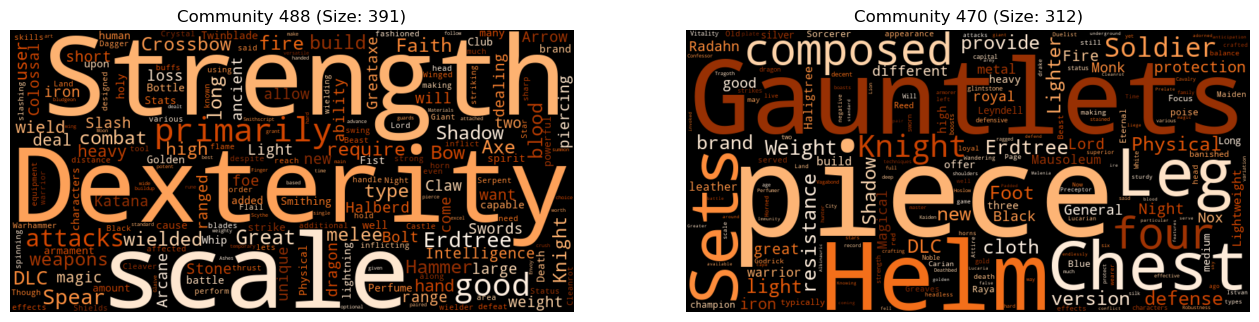

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud # requires: pip install wordcloud

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"
INPUT_PATH = PROCESSED_DIR / "nodes_analyzed.csv"

print(f"Loading analyzed data from: {INPUT_PATH}")
df = pd.read_csv(INPUT_PATH)

# Ensure description is string (handle NaNs from raw data)
df['description'] = df['description'].astype(str).fillna("")

# ==========================================
# 2. SENTIMENT ANALYSIS (Mood of the World)
# ==========================================
print("\n--- Calculating Sentiment ---")

def get_sentiment(text):
    # Skip very short text to avoid noise
    if len(text) < 5: return 0
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['description'].apply(get_sentiment)

# Show "Tragic" vs "Noble" items
print("Most Negative Descriptions (The Tragic):")
print(df[['name', 'sentiment']].sort_values('sentiment').head(5))

print("\nMost Positive Descriptions (The Noble/Divine):")
print(df[['name', 'sentiment']].sort_values('sentiment', ascending=False).head(5))

# Average sentiment by type
print("\nAverage Sentiment by Node Type:")
print(df.groupby('node_type')['sentiment'].mean().sort_values())

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# ==========================================
# 3. COMMUNITY KEYWORD EXTRACTION (Identifying Factions) - FILTERED
# ==========================================
print("\n--- Identifying Community Themes ---")

# 1. Define Custom Stop Words
# We start with the standard English list ('the', 'and', etc.)
# And add generic Elden Ring game terms that don't add lore value
custom_stop_words = list(ENGLISH_STOP_WORDS) + [
    "elden", "ring", "player", "target", "attack",
    "damage", "effect", "increase", "stat", "attribute",
    "character", "enemy", "enemies", "found", "location",
    "worn", "armor", "weapon", "incantation", "shield", "talisman", "item",
    "effect", "skill", "fp", "cost", "attack", "power", "damage", "negation",
    "guard", "boost", "increases", "attributes", "required", "scaling",
    "passive", "use", "equipped", "equipping", "sorcery", "spell", "consumable",
    "material", "upgrade", "ash", "war", "part", "set", "made", "found",
    # User requested removals:
    "one", "blade", "sword", "greatsword", "curved", "straight", "thrusting", "items", "NPC", "boss", "Bosses"
]

# 2. Aggregate text per community
community_docs = df.groupby('community')['description'].apply(lambda x: " ".join(x))

# 3. Run TF-IDF with Custom Stop Words
# stop_words=custom_stop_words: Tells the model to completely ignore the words above
tfidf = TfidfVectorizer(stop_words=custom_stop_words, max_df=0.6, max_features=1000)
tfidf_matrix = tfidf.fit_transform(community_docs)
feature_names = tfidf.get_feature_names_out()

# Helper to get top words for a specific community ID
def get_keywords(comm_id, top_n=8):
    if comm_id not in community_docs.index: return []
    row_idx = list(community_docs.index).index(comm_id)
    row = tfidf_matrix[row_idx]
    sorted_items = sorted(zip(row.indices, row.data), key=lambda x: x[1], reverse=True)[:top_n]
    return [feature_names[i] for i, score in sorted_items]

# 4. Print the List of Major Communities
top_communities = df['community'].value_counts().head(10).index.tolist()

print(f"{'ID':<5} | {'Size':<6} | {'Defining Keywords (The Vibe)'}")
print("-" * 80)

for comm_id in top_communities:
    size = len(df[df['community'] == comm_id])
    keywords = get_keywords(comm_id)
    kw_str = ", ".join(keywords)
    print(f"{comm_id:<5} | {size:<6} | {kw_str}")

from wordcloud import WordCloud, STOPWORDS

# ==========================================
# 4. VISUALIZATION (Word Clouds) - FILTERED
# ==========================================
print("\n--- Generating Word Clouds for Top 2 Factions ---")

# 1. Define your custom stopwords
# Start with the standard English list and add your own
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "elden", "ring", "player", "target", "attack",
    "damage", "effect", "increase", "stat", "attribute",
    "character", "enemy", "enemies", "found", "location",
    "worn", "armor", "weapon", "incantation", "shield", "talisman", "item",
    "effect", "skill", "fp", "cost", "attack", "power", "damage", "negation",
    "guard", "boost", "increases", "attributes", "required", "scaling",
    "passive", "use", "equipped", "equipping", "sorcery", "spell", "consumable",
    "material", "upgrade", "ash", "war", "part", "set", "made", "found",
    # User requested removals:
    "one", "blade", "sword", "greatsword", "curved", "straight", "thrusting", "items", "NPC", "boss", "Bosses", "used", "players", "locations"
])


plt.figure(figsize=(16, 8))

# Loop through top 2 communities
for i, comm_id in enumerate(top_communities[:2]):
    text = community_docs.loc[comm_id]

    # 2. Pass the stopwords to the generator
    wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Oranges',
        stopwords=custom_stopwords,  # <--- APPLY FILTER HERE
        collocations=False           # Optional: Prevents repeating bigrams like "Elden Ring"
    ).generate(text)

    plt.subplot(1, 2, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Community {comm_id} (Size: {len(df[df['community']==comm_id])})")

plt.show()

# Topology of the shattering (topological fragmentation 3.1)

Drawing the Map of the Shattering...


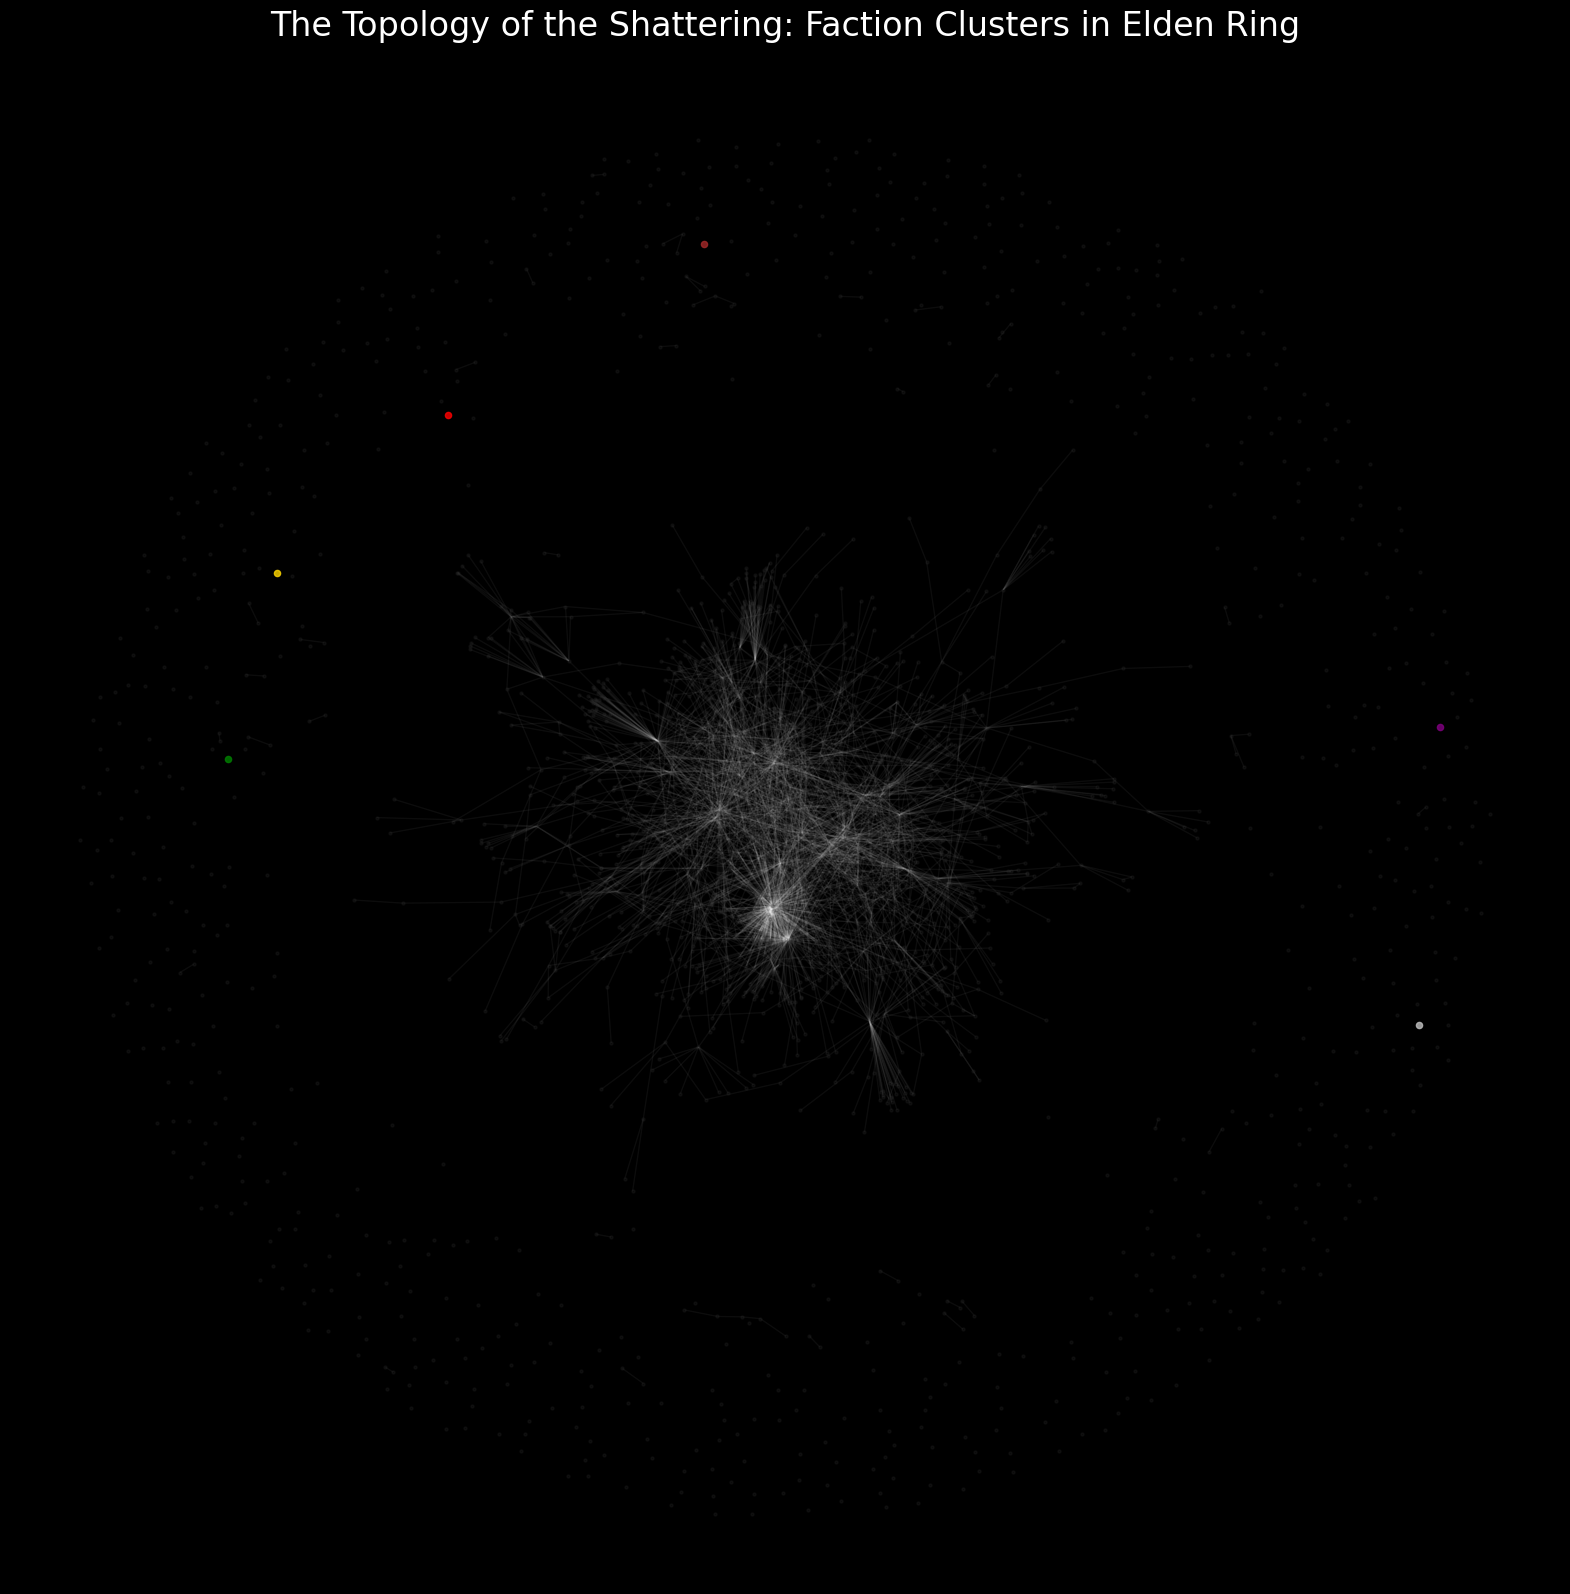

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# 1. Load Data
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"
nodes = pd.read_csv(PROCESSED_DIR / "nodes_analyzed.csv")
edges = pd.read_csv(PROCESSED_DIR / "edges_enriched.csv")

# 2. FILTER NOISE (CRITICAL STEP)
# We remove the Wiki Headers that are clogging your centrality list
noise_list = [
    "Strength", "Dexterity", "Intelligence", "Faith", "Arcane", 
    "Armor", "Weapons", "Bosses", "Items", "Ash of War",
    "Shadow of the Erdtree", "The Lands Between", "Status Effects",
    "Stats", "Runes", "Poison", "Scarlet Rot"
]
nodes_clean = nodes[~nodes['name'].isin(noise_list)]
valid_ids = set(nodes_clean['node_id'])

# Rebuild Graph with only clean nodes
G_vis = nx.Graph()
for _, row in nodes_clean.iterrows():
    G_vis.add_node(row['node_id'], community=row['community'], size=row['centrality'])

for _, row in edges.iterrows():
    if row['source'] in valid_ids and row['target'] in valid_ids:
        G_vis.add_edge(row['source'], row['target'])

# 3. Focus on the "Big 6" Factions (from your logs)
# Communities: 9 (Combat), 6 (Crafting), 41 (Knights), 100 (DLC), 126 (Rot), 81 (Roundtable)
top_comms = [9, 6, 41, 100, 126, 81]
node_colors = []
node_sizes = []
labels = {}

# Map ID to Name for labeling
id_to_name = dict(zip(nodes_clean['node_id'], nodes_clean['name']))

print("Drawing the Map of the Shattering...")
plt.figure(figsize=(20, 20), facecolor='black')

# Position nodes (Force Atlas equivalent)
pos = nx.spring_layout(G_vis, k=0.15, iterations=50, seed=42)

for node in G_vis.nodes():
    comm = G_vis.nodes[node]['community']
    
    # Color logic
    if comm == 126: color = 'red'       # Rot
    elif comm == 81: color = 'gold'     # Roundtable/Order
    elif comm == 100: color = 'purple'  # Shadow/DLC
    elif comm == 41: color = 'silver'   # Knights/Armor
    elif comm == 9: color = 'brown'     # Strength/Raw
    elif comm == 6: color = 'green'     # Crafting/Nature
    else: color = 'grey'                # Others
    
    # Size logic (boost hubs)
    cent = G_vis.nodes[node]['size']
    size = max(20, cent * 5000) 
    
    # Label logic (Only label significant nodes)
    if cent > 0.005 and comm in top_comms:
        labels[node] = id_to_name.get(node, "")
        
    # Draw logic
    if comm in top_comms:
        nx.draw_networkx_nodes(G_vis, pos, nodelist=[node], node_color=color, node_size=size, alpha=0.8)
    else:
        # Draw background nodes smaller and fainter
        nx.draw_networkx_nodes(G_vis, pos, nodelist=[node], node_color='#333333', node_size=5, alpha=0.2)

# Draw Faint Edges
nx.draw_networkx_edges(G_vis, pos, alpha=0.05, edge_color='white')

# Draw Labels
nx.draw_networkx_labels(G_vis, pos, labels, font_color='white', font_size=10, font_weight='bold')

plt.title("The Topology of the Shattering: Faction Clusters in Elden Ring", color='white', fontsize=24)
plt.axis('off')
plt.show()

### Golden order propaganda 3.2

Calculating sentiment for visualization...


C:\Users\marwa\AppData\Local\Temp\ipykernel_17628\3538624713.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Category', y='sentiment', data=plot_df,


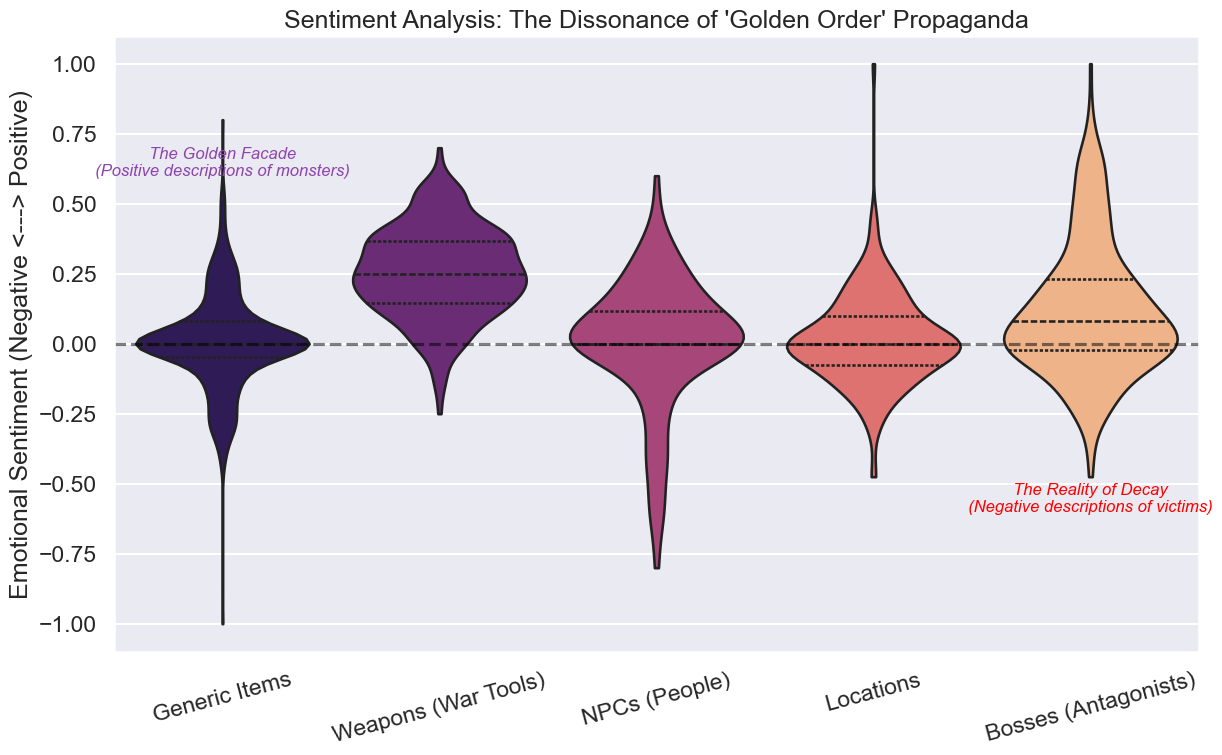

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
from pathlib import Path

# 1. Load Data
# Detect project root
project_root = Path.cwd()
while not (project_root / "data").exists() and project_root.parent != project_root:
    project_root = project_root.parent

PROCESSED_DIR = project_root / "data" / "processed"
# (We use the file you already have, which contains Community and Centrality)
df = pd.read_csv(PROCESSED_DIR / "nodes_analyzed.csv")

# 2. CRITICAL STEP: Calculate Sentiment
# The file from Notebook 03 doesn't have this column, so we must generate it here.
print("Calculating sentiment for visualization...")
def get_sentiment(text):
    # Handle missing or non-string values safely
    if pd.isna(text): return 0
    text_str = str(text)
    if len(text_str) < 5: return 0
    return TextBlob(text_str).sentiment.polarity

df['sentiment'] = df['description'].apply(get_sentiment)

# 3. Filter for the relevant narrative categories
target_types = ['boss', 'weapon', 'npc', 'location', 'item']
plot_df = df[df['node_type'].isin(target_types)].copy()

# Rename for cleaner plot labels
type_map = {
    'boss': 'Bosses (Antagonists)',
    'weapon': 'Weapons (War Tools)',
    'npc': 'NPCs (People)',
    'location': 'Locations',
    'item': 'Generic Items'
}
plot_df['Category'] = plot_df['node_type'].map(type_map)

# 4. PLOT
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")
sns.set_context("talk")

# Violin Plot showing density of sentiment
ax = sns.violinplot(x='Category', y='sentiment', data=plot_df, 
                    palette="magma", inner="quartile", cut=0)

# Add Reference Line (Neutral)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)

# Annotate the "Propaganda"
plt.text(0, 0.6, "The Golden Facade\n(Positive descriptions of monsters)", 
         color='#8e44ad', ha='center', fontsize=12, style='italic')

plt.text(4, -0.6, "The Reality of Decay\n(Negative descriptions of victims)", 
         color='red', ha='center', fontsize=12, style='italic')

plt.title("Sentiment Analysis: The Dissonance of 'Golden Order' Propaganda", fontsize=18)
plt.ylabel("Emotional Sentiment (Negative <---> Positive)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.show()

## The Tragedy of Commerce (Sociological Findings)

C:\Users\marwa\AppData\Local\Temp\ipykernel_17628\3008051826.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='death_ref_count', y='name', data=top_tragic, palette="Reds_r")


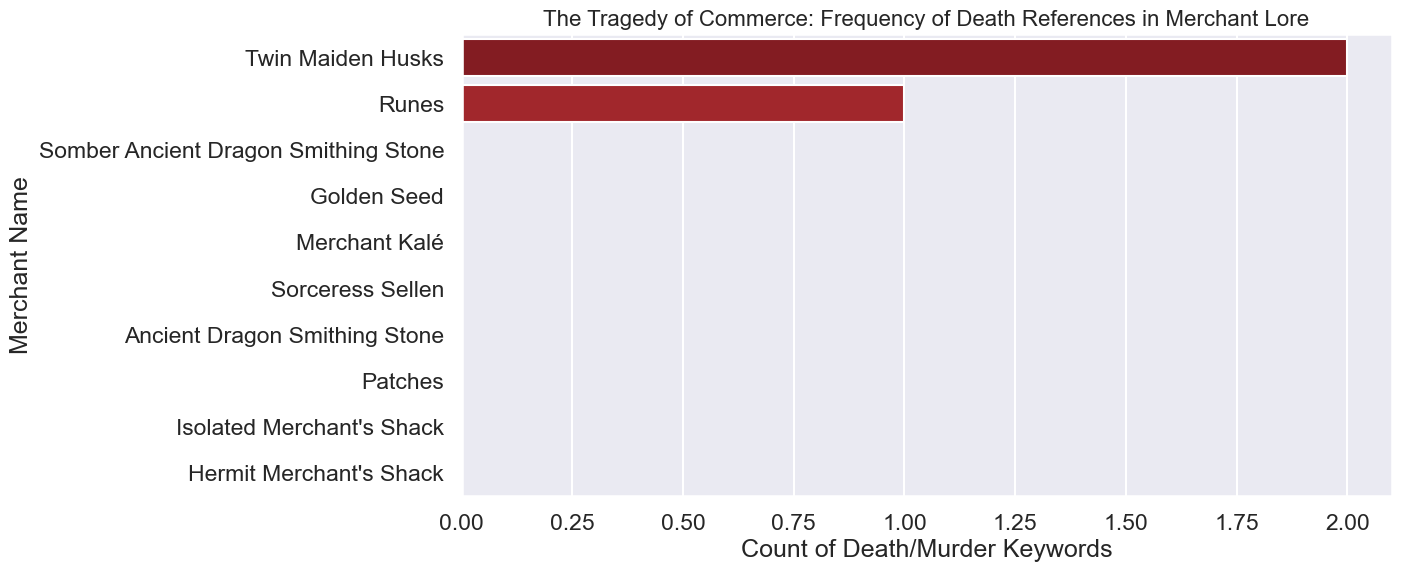

In [22]:
# Create a specific dataframe for Merchants
merchants = df[df['name'].str.contains("Merchant") | df['description'].str.contains("Merchant")].copy()

# Define Tragic Keywords
death_words = ['bell bearing', 'dead', 'corpse', 'killed', 'die', 'murder', 'hunter']
merchants['death_ref_count'] = merchants['description'].apply(lambda x: sum(1 for w in death_words if w in str(x).lower()))

# Sort by Tragedy
top_tragic = merchants.sort_values('death_ref_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='death_ref_count', y='name', data=top_tragic, palette="Reds_r")
plt.title("The Tragedy of Commerce: Frequency of Death References in Merchant Lore", fontsize=16)
plt.xlabel("Count of Death/Murder Keywords")
plt.ylabel("Merchant Name")
plt.show()